# Source Code for implementing ACO for the MAPF problem

* Create algorithm for ACO (done)
* Create test promles (done / more or less)
* Create algorithm for time-expansion of the graph (working)
* Create Multi-Agent-ACO solver

Working Title: "Cooperative Co-Evolution of Intent: Soving the Multi-Agent Path Finding Problem with Ant Colony Optimisation"

Abstract:
* ACO is used to solve path finding problems in graphs
* The pheromone-matrix represents the intent of an agent
* A solution to the MAPF can be viewed as a state of consent of intentions
* Two problems need to be solved: 
    * Time Extension of ACO
    * Ants that consider other agents intent
* Experiments: in progress
* Works?

In [1]:
# install the required packages
%pip install matplotlib pandas seaborn numpy networkx ipywidgets netgraph ipympl

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(threshold=np.inf)
import networkx as nx
import ipywidgets as widgets

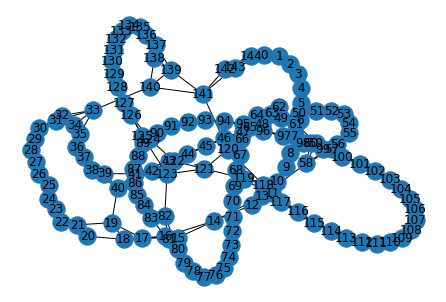

In [3]:
G = nx.watts_strogatz_graph(145,4, 0.01, seed=42)
nx.draw(G,with_labels=True)
for e in G.edges():
    G[e[0]][e[1]]['weight']= 0.5 + np.random.rand()
graphstart = 0
graphgoal = 75

m = nx.adj_matrix(G)
p = np.ones_like(m.todense())

In [4]:
class Ant:
    def __init__(self, start = 0, goal = None, pheromones = None, adjacency = None):
        self.start = start
        self.goal = goal
        self.pheromones = pheromones
        self.adjacency = adjacency
        self.stuck = False
        self.selection = self.ant_system_selection
        self.forward = True
        
        self.setup()
        
        
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize(self, value = 0.5):
        factor = 1 * self.pheromones.shape[0] / np.sum(self.pheromones)
        np.multiply(self.pheromones, factor, out=self.pheromones)
        
    def delayed_update(self):
        amount = 1/self.distance
        for i in range(len(self.path)-1):
            self.pheromones[self.path[i], self.path[i+1]] += amount #/ self.adjacency[self.path[i], self.path[i+1]]
    
    def random_selection(self, new):
        return np.random.choice(new)
    
    def value(self, i, j, alpha=0.5, beta=0.5, **kwargs):
        if not self.forward:
            i, j = j, i
        d = self.adjacency[i,j]
        return np.max([np.finfo(float).eps,self.pheromones[i,j]])**alpha * (1/d)**beta
    
    def ant_system_selection(self,state, new, **kwargs):
        probs = {k : self.value(state, k, **kwargs) for k in new }
        cutoff = np.random.rand()
        s = sum(probs.values())
        x = new[-1]
        for k, v in probs.items():
            cutoff -= v / s
            if cutoff < 0:
                return k
        if cutoff < 0:
            print(f"cutoff:{cutoff} < 0 - should not happen")
            print(probs)
        return x
    
    def get_time(self):
        return len(self.path)-1
    
    def roulette_wheel_selection(self, state ,new):
        probs = {k : self.pheromones[state, k] for k in new }
        cutoff = np.random.rand()
        s = sum(probs.values())
        x = new[-1]
        for k, v in probs.items():
            cutoff -= v / s
            if cutoff < 0:
                x = k
                break
        assert(cutoff <= 0)
        return x

    def setup(self, start=None, goal=None, invert_direction=False, **kwargs):
        if start:
            self.start = start
        if goal:
            self.goal = goal
            
        if invert_direction:
            self.start, self.goal = self.goal, self.start
            self.forward = not self.forward
        self.stuck = False
        self.state = self.start
        self.path = [self.start]
        self.distance = 0
            
    def step(self, selection=None, allow_revisit=False, allow_wait=False, **kwargs):
        if selection:
            self.selection = selection
        if not self.selection:
            self.selection = self.ant_system_selection
        
        # compute next possible states $new
        new = [node for node in range(len(self.adjacency))]
        if not (allow_revisit and self.forward):
            new = [node for node in new if not (node in self.path)]
        
        new = [node for node in new if not (self.adjacency[self.state, node] == 0)]
        
        if allow_wait and self.forward:
            new.append(self.state)
        
        # in case no more states are possible: return
        if not new:
            self.stuck=True
            return
        
        # pick a new state from the list
        self.state = self.selection(self.state, new, forward=self.forward, **kwargs)
        self.path.append(self.state)
        d = self.adjacency[self.path[-2], self.path[-1]]
        #print(f"current distance: {d}")
        self.distance += d
        

class ACO:
    def __init__(self, start = 0, goal = None, pheromones = None, adjacency = None, **kwargs):
        self.start = start
        self.goal = goal
        self.adjacency = adjacency
        if pheromones is not None:
            self.pheromones = pheromones
        else:
            self.pheromones = np.ones_like(self.adjacency)
        self.best_distance = np.inf
        self.best_path = [start]
        self.kwargs = kwargs
        assert self.pheromones.shape == self.adjacency.shape
        for i in range(self.adjacency.shape[0]):
            for j in range(self.adjacency.shape[1]):
                if self.adjacency[i, j] == 0:
                    self.pheromones[i, j] = 0
        
        self.pheromone_timeline = [self.pheromones.copy()]
        self.distance_timeline = [self.best_distance]
        self.create_ants()

        
    def create_ants(self, num_ants = 10):
        self.ants = [Ant(start=self.start, goal=self.goal, pheromones=self.pheromones, adjacency=self.adjacency) for _ in range(num_ants)]
   
    def online_pheromone_update(self, **kwargs):
        for ant in self.ants:
            amount = 1 / self.adjacency[ant.path[-2],ant.path[-1]]
            if ant.forward:
                self.pheromones[ant.path[-2], ant.path[-1]] += amount
            else:
                self.pheromones[ant.path[-1], ant.path[-2]] += amount
                
            
    def delayed_online_pheromone_update(self, **kwargs):
        for ant in self.ants:
            if ant.state == ant.goal:
                amount = 1 / ant.distance
                path = ant.path
                if not ant.forward:
                    path.reverse()
                for i in range(len(path) - 1):
                    self.pheromones[path[i], path[i+1]] += amount
    
    def penalize_stuck(self, stuck_penalty=0.1, **kwargs):
        for ant in self.ants:
            if ant.stuck:
                self.pheromones[ant.path[-2], ant.path[-1]] += -stuck_penalty
        
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize(self, gamma = 1, normalize_eps=0, **kwargs):
        self.pheromones -= normalize_eps
        np.clip(np.inf, 0, self.pheromones, out=self.pheromones)
        factor = gamma * self.pheromones.shape[0] / np.sum(self.pheromones)
        np.multiply(self.pheromones, factor, out=self.pheromones)
        
        
    def step(self, **kwargs):
        for ant in self.ants:
            ant.step(**kwargs)

    def daemon_actions(self, reverse_ants=True, **kwargs):
        """perform daemon actions
        * Reset ants that have arrived
        
        Keyword Arguments:
        reverse_ants -- if True the goal and start will be swapped before the ant is reset
        """
        for ant in self.ants:
            if ant.stuck:
                ant.setup()
            if ant.state == ant.goal:
                if ant.distance < self.best_distance:
                    self.best_distance = ant.distance
                    self.best_path = ant.path
                ant.setup(invert_direction=reverse_ants)
        self.distance_timeline.append(self.best_distance)
    
    
    def update_pheromones(self, delayed_update=True, evaporation_method="normalize", log_pheromones=True, penalize_stuck=False, elitist_update=False, **kwargs):
        """updates the pheromone matrix
    
        Keyword Arguments:
        delayed_update -- bool telling to perform the pheromone update after each step or when the ant reaches the goal
        evaporation_method -- tell the algorithm how to perform evaporation ("normalize" or "evaporate")
        gamma -- rate of evaporation (depends on evaporation_method)
        """
        if delayed_update:
            self.delayed_online_pheromone_update(**kwargs)
        else:
            self.online_pheromone_update(**kwargs)
        
        if elitist_update:
            amount = 1 / self.best_distance / len(self.ants)
            for i in range(len(self.best_path) - 1):
                self.pheromones[self.best_path[i], self.best_path[i+1]] += amount
                
        
        # evaporation
        if evaporation_method == "normalize":
            self.normalize(**kwargs)
        elif evaporation_method == "evaporate":
            self.evaporate(**kwargs)
        
        if penalize_stuck:
            self.penalize_stuck(**kwargs)
        
        #np.clip( self.pheromones,0, np.inf, out=self.pheromones)
        if log_pheromones:
            self.pheromone_timeline.append(self.pheromones.copy())
            
            
    def run(self, generations=1000, **kwargs):
        self.kwargs.update(kwargs)
        for generation in range(generations):
            self.step(**self.kwargs)
            self.update_pheromones(**self.kwargs)
            self.daemon_actions(**self.kwargs)
            
    def draw_pheromones(self, label=True, generation=-1, width=15, height=15, thickness=3, show=True, prune=0, node_label=True):
        print(f"Best Distance Found: {self.distance_timeline[generation]}\n{self.best_path}")
        plt.figure(figsize=(width,height))
        G = nx.from_numpy_matrix(self.pheromone_timeline[generation], create_using=nx.DiGraph())
        Ga = nx.from_numpy_matrix(self.adjacency)
        pos = nx.kamada_kawai_layout(Ga)
        weight = nx.get_edge_attributes(G,'weight')
        node_colors = ["lightblue" for _ in range(self.pheromones.shape[0])]
        node_colors[self.start] = "red"
        node_colors[self.goal] = "green"
        labels = { k : f"{v:.2f}" for k, v in weight.items()}
        width = [(max(prune, w['weight']) - prune) * thickness for u, v, w in G.edges(data=True)]
        nx.draw_networkx_nodes(G,pos=pos,with_labels=True, node_color=node_colors)
        nx.draw_networkx_edges(G,pos, width=width, alpha=0.3, connectionstyle='arc3,rad=0.2', arrowstyle="-|>", arraowsize=thickness*3)
        if node_label:
            nx.draw_networkx_labels(G, pos=pos)

        if label:
            nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, label_pos=0.3)
            
        if show:
            plt.show()
    
    def draw_adjacency(self):
        G = nx.from_numpy_matrix(self.adjacency)
        pos=nx.kamada_kawai_layout(G)
        nx.draw(G,pos=pos,with_labels=True)
        weight = nx.get_edge_attributes(G,'weight')
        labels = { k : f"{v:.1f}" for k, v in weight.items()}
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        
        


Best Distance Found: 10.777759815830798
[0, 143, 141, 120, 121, 122, 123, 82, 80, 79, 77, 75]


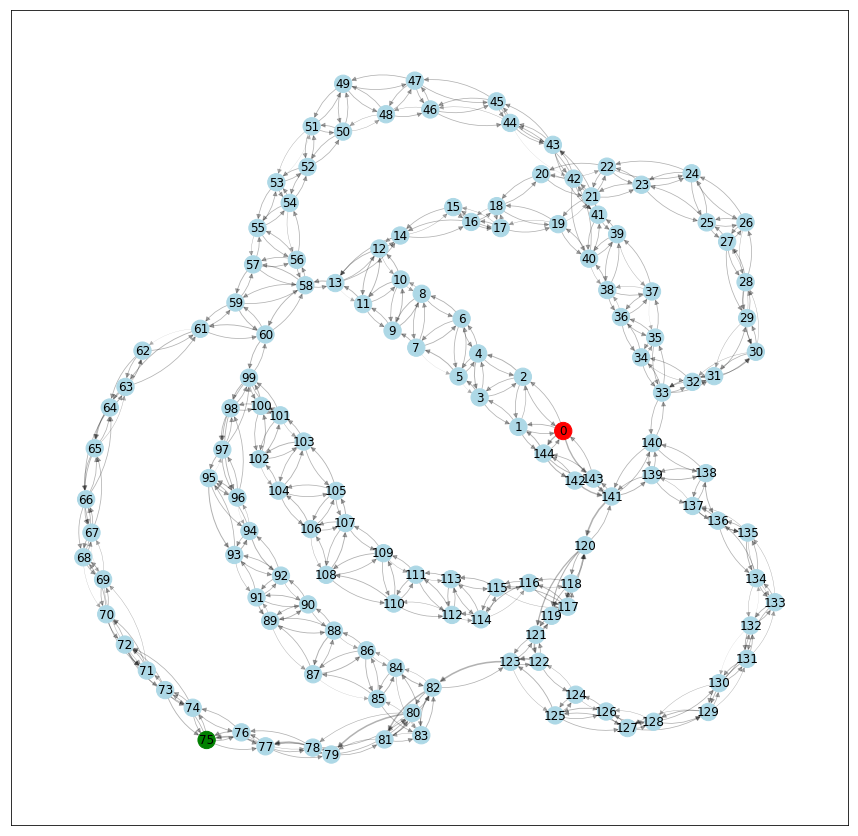

In [5]:
m = nx.adj_matrix(G)
p = np.ones_like(m.todense())
aco = ACO(start=graphstart, goal=graphgoal, pheromones=p, adjacency=m.todense())
aco.run(generations=300, elitst_update=True, alpha=0.8, beta=0.2, reverse_ants=True, penalize_stuck=True)
aco.draw_pheromones(label=False)

In [6]:
widgets.interact(aco.draw_pheromones, label=False, width=15, height=15, show=widgets.fixed(True),prune=widgets.FloatSlider(value=0.1, min=0.0, max=0.50, step=0.05), generation=widgets.IntSlider(min=0,max=len(aco.pheromone_timeline)-1,step=1,value=0));

interactive(children=(Checkbox(value=False, description='label'), IntSlider(value=0, description='generation',…

In [7]:
aco.run(generations=2000, alpha=1, beta=0)

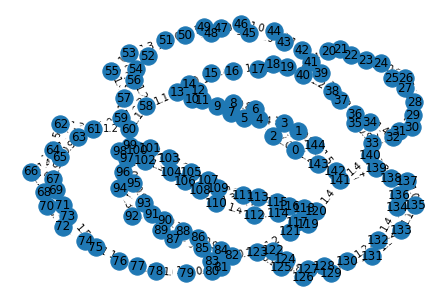

In [8]:
aco.draw_adjacency()

In [9]:
aco.best_path

[0, 143, 141, 120, 121, 123, 82, 80, 78, 77, 75]

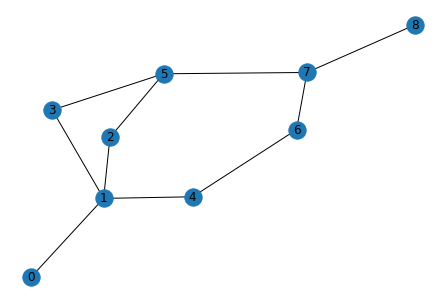

In [10]:
G = nx.Graph()
G.add_edge(0, 1, weight=1)
G.add_edge(1, 2, weight=1.5)
G.add_edge(1, 3, weight=1)
G.add_edge(3, 5, weight=1)
G.add_edge(1, 4, weight=3)
G.add_edge(2, 5, weight=1)
G.add_edge(4, 6, weight=1)
G.add_edge(5, 7, weight=1)
G.add_edge(6, 7, weight=3)
G.add_edge(7, 8, weight=1)
#G.add_edge(5, 9)
nx.draw(G, with_labels=True)
graphstart = 0
graphgoal = 8

m = nx.adj_matrix(G)
p = np.ones_like(m.todense())

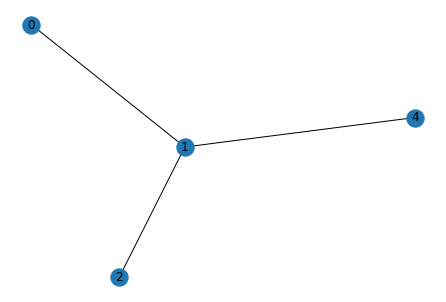

In [11]:
G = nx.Graph()
G.add_edge(0, 1, weight=1.0)
G.add_edge(1, 2, weight=1.5)
G.add_edge(1, 4, weight=1.0)
nx.draw(G, with_labels=True)
graphstart = 0
graphgoal = 3

m = nx.adj_matrix(G)
p = np.ones_like(m.todense())

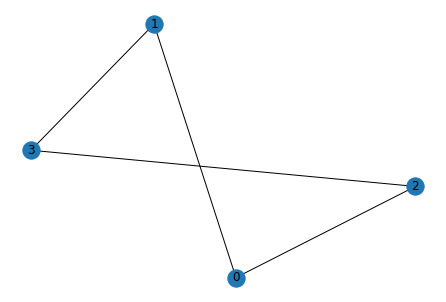

In [12]:
G = nx.Graph()
G.add_edge(0, 1, weight=1.0)
G.add_edge(0, 2, weight=1.0)
G.add_edge(1, 3, weight=1.0)
G.add_edge(2, 3, weight=1.0)
nx.draw(G, with_labels=True)
graphstart = 0
graphgoal = 3

m = nx.adj_matrix(G)
p = np.ones_like(m.todense())

## Time extension and foreign Agent ... of ACO

### Time Extension
Time extension works by unrolling the pheromone matrix throughout time. In each time step t the pheromone matrix $\mathcal{P}(t)$ is used for the pheromone update.
The values $\tau_{ij, t}$ are updated after an ant reaches the goal. In the time extended form, circular paths (in space) and waiting is also allowed.

There are two decision rules governing the behaviour of the ants. On its way from start to goal the ant follows the (time-)global pheromone matrix $P$, the time extended pheromone matrix $\mathcal{P}(t)$ and the foreign time extended pheromones at the current timestep $\mathcal{P}_{f}(t)$.
As paths can be simliar through time the actual matrix used instead of $\mathcal{P}(t)$ is $\sum_{i=t-k}^{t+k} \mathcal{P}(i)$ with $k=3$.

#### Decision Rule

\begin{equation}
v = \big(\frac{1}{p_{c} + \varepsilon_f}\big)^{\alpha_f} \cdot \Big(\sum_{i=t-k}^{t+k} \mathcal{P}(i)\Big)_{ij}^{\alpha} \cdot \tau_{ij}^{\beta} + \varepsilon
\end{equation}

#### Update Rule
Each node in the path will get this amount of pheromones:
\begin{equation}
v = \big( \frac{c_t |\mathcal{T}|}{t_{goal}} + \frac{c_d}{\sum{d_e}} + \frac{c_f}{\sum{\mathcal{P}_f(t)_{ij}}} \big)
\end{equation}


In [6]:

class TimeExtendedACO(ACO):
    def __init__(self, timeframe=100, prerun_generations=1000, **kwargs):
        ACO.__init__(self, **kwargs)
        self.node_count = np.zeros((self.adjacency.shape[0], timeframe), dtype=int)
        self.node_sucess = np.zeros_like(self.node_count, dtype=int)
        self.df_convergence = pd.DataFrame()
        #print(f"prerun for {prerun_generations} generations")
        self.run(generations=prerun_generations, **kwargs)
        self.extended_pheromones = np.ones((timeframe, self.pheromones.shape[0], self.pheromones.shape[1]))
        self.timeframe = timeframe
        self.best_path = []
        self.best_distance = np.inf
        self.iteration = 0
        # create new ants outside of the current graph
        self.create_ants()
        self.arrived = 0
        self.timeout = 0
        for ant in self.ants:
            ant.forward = True
            ant.selection = self.tAco_selection
            ant.penalty = np.zeros_like(self.pheromones)
        #for t in range(timeframe):
            #self.extended_pheromones[t] = self.pheromones
    
    def edge_collision_pheromones(self, i, j, foreign_pheromones=None):
        return foreign_pheromones[j, i] + foreign_pheromones[i, j]
    
    def node_collision_pheromones(self, j, foreign_pheromones=None):
        return np.sum(foreign_pheromones[:,j])
     
    def tAco_selection_value(self, i, j, edge_collision_factor=3, extended_pheromones=None, foreign_pheromones=None, alpha=0.5, eps=0.0001, beta=0.5, forward=True, alpha_foreign=1,**kwargs):
        """computes the fitness value of a particular edge
        parameters:
        i -- from
        j -- to
        
        extended_pheromones -- time extended pheromone matrix
        alpha -- weight of the pheromone matrix
        eps -- fixed value added to all the options (high eps -> random walk)
        beta -- weight of the extended pheromone matrix
        forward -- if False, i and j are swapped
        """
        if not forward:
            #print("test")
            i, j = j, i
            
        p = np.max([np.finfo(float).eps, self.pheromones[i, j]])
        p_ext = np.max([np.finfo(float).eps, extended_pheromones[i, j]])
        
        #if foreign_phermones == None or not forward:
        p_foreign = 1
        if forward and foreign_pheromones is not None:
            #sum of the foreign pheromones going to the new node
            # -> no node collisions
            p_foreign = self.node_collision_pheromones(j, foreign_pheromones=foreign_pheromones)
            
            #backward edge- no edge collisions
            p_foreign += self.edge_collision_factor * self.edge_collision_pheromones(i, j, foreign_pheromones=foreign_pheromones)
            
            #print(f"tAcoSelection_value- {i}, {j}: p: {p}, p_ext: {p_ext}, p_foreign:{p_foreign},  {p**alpha * p_ext**beta * (1 / (eps + p_foreign) ** alpha_foreign) + eps}")
        return  p**alpha * p_ext**beta * (1 / (eps + p_foreign**alpha_foreign)) + eps
    
    def extended_pheromones_sum(self):
        """normalized sum (over all time steps) of the time extended pheromone values"""
        return self.normalize_(np.sum(self.extended_pheromones, axis=0))
    
    def extended_pheromone_convolution(self, t, length=3, function=lambda x: 2 / abs(x + 1), argument=None):
        if argument is None:
            argument = self.extended_pheromones
        matrix = np.zeros_like(argument[t])
        for x in range(max(0, t-length), t+length):
            matrix += argument[x] * function(x)
        return self.normalize_(matrix)
    
    def tAco_selection(self, state, new, time=0, forward=True, foreign_pheromones=None, **kwargs):
        """select the next action based on time extended pheromones
        forward: select based on current time-step pheromone matrix
        backward: select based on sum of time extended pheromones
        """
        #print(f"tAcoSelection- state: {state}, new: {new}, time: {time}")
        probs = {}
        if forward:
            if foreign_pheromones is None:
                probs = {k : self.tAco_selection_value(state, k, extended_pheromones=self.extended_pheromone_convolution(time), **kwargs) for k in new }
            else:
                #print("there are foreign pheromones in tAco_selection")
                probs = {k : self.tAco_selection_value(state, k, extended_pheromones=self.extended_pheromone_convolution(time), foreign_pheromones=foreign_pheromones[time], **kwargs) for k in new }
        else:
            probs = {k : self.tAco_selection_value(state, k, extended_pheromones=self.extended_pheromones_sum(), forward=forward, **kwargs) for k in new }
        
        #print(probs)
        
        cutoff = np.random.rand()
        s = sum(probs.values())
        x = new[0]
        for k, v in probs.items():
            cutoff -= v / s
            if cutoff < 0:
                #print(f"tAcoSelection- {probs} -- selected: {k}")
                return k
        if cutoff > 0:
            print(f"cutoff:{cutoff} > 0 - should not happen")
            print(probs)
        return x
    
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize_(self, pheromones, gamma = 1, normalize_eps=0.0, **kwargs):
        x = np.clip(np.inf, 0, pheromones - normalize_eps)
        factor = gamma * x.shape[0] / np.sum(x)
        return x * factor
    
    def extended_step(self, **kwargs):
        for ant in self.ants:
            assert (ant.start == self.start) or not ant.forward
            if ant.forward:
                ant.step(selection=self.tAco_selection, allow_revisit=True, allow_wait=True, **kwargs)
            else:
                ant.step(selection=self.tAco_selection, allow_revisit=False, allow_wait=False, **kwargs)
            
    def run_extended(self, generations=1000, foreign_pheromones=None, show_progress=False,**kwargs):
        if show_progress:
            progress_bar = widgets.IntProgress(min=0, max=generations, description=f"computing {generations} generations")
            display(progress_bar)
        self.kwargs.update(kwargs)
        data = [self.df_convergence]
        for generation in range(generations):
            if show_progress:
                progress_bar.value = generation
            self.iteration += 1
            if self.iteration % 1000 == 0:
                print(f"iteration {self.iteration} --  arrived: {self.arrived}, timeout: {self.timeout}, ratio: {self.arrived / (self.arrived + self.timeout)}")
            self.extended_step(foreign_pheromones=foreign_pheromones, **self.kwargs)
            self.extended_update_pheromones(**self.kwargs)
            self.extended_daemon_actions(**self.kwargs)
            data.append(pd.DataFrame({"iteration":self.iteration, "arrived": self.arrived, "timout":self.timeout, "shortest":self.best_distance}, index=[self.iteration]))
        self.df_convergence = pd.concat(data)
            
    def extended_daemon_actions(self, reverse_ants=True, penalty_factor=0.01, depenalize_long_running=True, **kwargs):
        """perform daemon actions
        * Reset ants that have arrived
        
        Keyword Arguments:
        reverse_ants -- if True the goal and start will be swapped before the ant is reset
        """
        for ant in self.ants:
            if ant.get_time() >= self.timeframe:
                #print(f"ant did not arrive {ant.path}")
                if depenalize_long_running:
                    self.depenalize_path(ant, penalty_factor)
                ant.setup()
                self.timeout += 1
                
            if ant.stuck:
                if ant.forward:
                    print("forward, should not be stuck")
                ant.setup()
            if ant.state == ant.goal:
                if ant.forward:
                    self.arrived += 1
                    for t in range(len(ant.path)):
                        self.node_count[ant.path[t],t] += 1
                    #print(f"ant arrived afer {ant.get_time()} steps: {ant.path} ")
                if ant.distance < self.best_distance:
                    self.best_distance = ant.distance
                    self.best_path = ant.path
                ant.setup(invert_direction=reverse_ants)
        self.distance_timeline.append(self.best_distance)
    
    def been_there_done_that_penalty(self, path):
        """add fixed amount of penalty for every edge and every node visited"""
        penalty = np.zeros_like(self.pheromones)
        for n1, n2 in zip(path[1:], path[:-1]):
            penalty[n1, n2] = -1
            penalty[n2, n1] = -1
            #penalty[n1, n1] = -1
        return penalty
            
    
    def extended_online_pheromone_update(self, penalty_factor = 0.01, **kwargs):
        """lower the pheromones in future nodes, where the ant has alreadd visited in the past"""
        for ant in self.ants:
            if ant.forward:
                for t in range(ant.get_time(), self.timeframe):
                    self.extended_pheromones[t] = self.extended_pheromones[t] + penalty_factor * self.been_there_done_that_penalty(ant.path)
    
    def depenalize_path(self, ant, penalty_factor, **kwargs):
        """reverse the penalty of an ant"""
        for t in range(0,ant.get_time()):
            for t2 in range(t, self.timeframe):
                penalty = penalty_factor * self.been_there_done_that_penalty(ant.path[:t])
                self.extended_pheromones[t2] -= penalty
                    
                    
        
    
    def extended_delayed_online_pheromone_update(self, c_d=1.0, c_t=0.5, c_amount=10, penalty_factor = 0.01, **kwargs):
        """reverse the penalty for moving backward and put more pheromones on the path"""
        for ant in self.ants:
            if ant.forward and ant.state==ant.goal:
                # in case the goal is reached, reverse the penalty for moving backwards, for all time steps
                self.depenalize_path(ant, penalty_factor)
                path = ant.path + [ant.goal for _ in range(ant.get_time(), self.timeframe)]
                for t in range(0,self.timeframe):
                    # put pheromones on the path depending on path fitness
                    amount = c_amount * (c_d / ant.distance +  c_t * self.timeframe/ant.get_time())
                    self.extended_pheromones[t][path[t], path[t+1]] += amount
            elif not ant.forward and ant.state==ant.goal:
                amount = 1 / ant.distance
                # put pheromone on the backward edges of the (backward) path
                for i, j in zip(ant.path[:-1], ant.path[1:]):
                    self.pheromones[j, i] += amount
                

    def extended_update_pheromones(self, node_pheromon=True, evaporation_method="normalize", normalize_eps=0.0, log_pheromones=True, penalize_stuck=False, elitist_update=False, **kwargs):
        """updates the pheromone matrix
    
        Keyword Arguments:
        delayed_update -- bool telling to perform the pheromone update after each step or when the ant reaches the goal
        evaporation_method -- tell the algorithm how to perform evaporation ("normalize" or "evaporate")
        gamma -- rate of evaporation (depends on evaporation_method)
        """
        
        # the online pheromone update penalizes already visited nodes in future time-steps the penalty is lifted once the ant reaches the goal
        self.extended_online_pheromone_update(**kwargs)
        
        # the delayed update reverses the penalty once the ant reaches the goal and puts extra pheromones on the travelled path (depending on fitness)
        self.extended_delayed_online_pheromone_update(**kwargs)
        
        if elitist_update:
            amount = 1 / self.best_distance / self.num_ants
            for i in range(len(self.best_path) - 1):
                if ant.forward:
                    self.pheromones[self.best_path[i], self.best_path[i+1]] += amount
        
        # evaporation
        if evaporation_method == "normalize":
            self.pheromones = self.normalize_(self.pheromones, normalize_eps=normalize_eps)
            for t in range(self.timeframe):
                self.extended_pheromones[t] = self.normalize_(self.extended_pheromones[t], normalize_eps=normalize_eps)
        elif evaporation_method == "evaporate":
            self.evaporate(**kwargs)
        
        if penalize_stuck:
            self.penalize_stuck(**kwargs)
        
        #np.clip( self.pheromones,0, np.inf, out=self.pheromones)
        if log_pheromones:
            self.pheromone_timeline.append(self.pheromones.copy())
            
        
    def draw_extended_pheromones(self, label=True, time=-1, width=15, height=15, thickness=3, show=True, prune=0, node_label=True):
        plt.figure(figsize=(width,height))
        matrix = None
        if time >= 0:
            matrix = self.extended_pheromones[time]
        else:
            matrix = self.extended_pheromones_sum()
        G = nx.from_numpy_matrix(matrix, create_using=nx.DiGraph())
        
        Ga = nx.from_numpy_matrix(self.adjacency)
        pos = nx.kamada_kawai_layout(Ga)
        weight = nx.get_edge_attributes(G,'weight')
        node_colors = ["lightblue" for _ in range(self.pheromones.shape[0])]
        node_colors[self.start] = "red"
        node_colors[self.goal] = "green"
        labels = { k : f"{v:.2f}" for k, v in weight.items()}
        width = [(max(prune, w['weight']) - prune) * thickness /np.max(matrix) for u, v, w in G.edges(data=True)]
        nx.draw_networkx_nodes(G,pos=pos, node_color=node_colors, node_size=[150 * (1 + v) for v in np.diag(matrix)])
        nx.draw_networkx_edges(G,pos, width=width, alpha=0.3, connectionstyle='arc3,rad=0.2', arrowstyle="-|>", arraowsize=thickness*3)
        if node_label:
            node_labels=None
            if label:
                node_labels = {k : f"{np.diag(matrix)[k]:.2f}" for k in range(matrix.shape[0])}
            nx.draw_networkx_labels(G, pos=pos, labels=node_labels)

        if label:
            nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, label_pos=0.3)
            
        if show:
            plt.show()
    
    def plot_convergence(self, show=True, order=2):
        sns.lmplot(data=self.df_convergence.loc[self.df_convergence.iteration % 100 == 0], x="iteration", y="arrived", order=order)
        if show:
            plt.show()
        
    

Best Distance Found: 10.403321283818794
[]


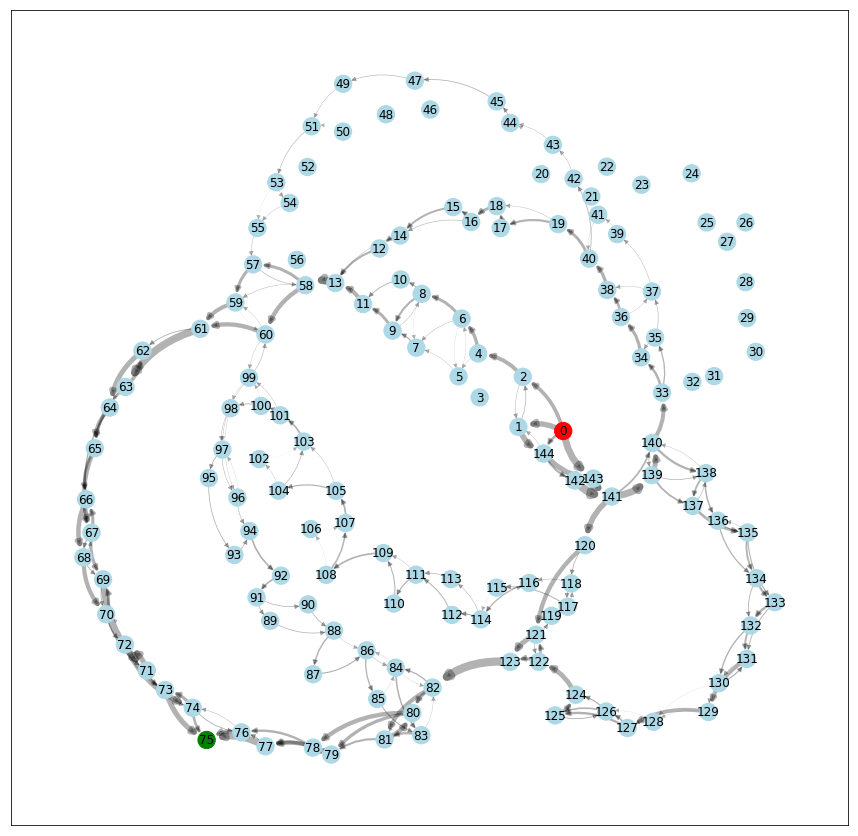

IntProgress(value=0, description='computing 1000 generations', max=1000)

iteration 1000 --  arrived: 124, timeout: 83, ratio: 0.5990338164251208


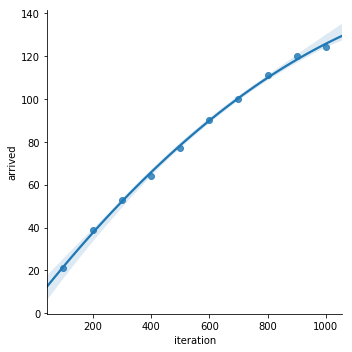

In [7]:
tAco = TimeExtendedACO(prerun_generations=1000, adjacency=m.todense(), pheromones=np.ones_like(m.todense()), start=graphstart, goal=graphgoal, timeframe=40, normalize_eps=0.001, elitist_update=False)
tAco.draw_pheromones(label=False)
tAco.run_extended(generations=1000, depenalize_long_running=False, alpha=0.5, beta=0.5, eps=0.001, penalty_factor=0.00, normalize_eps=0, elitist_update=False, show_progress=True)
tAco.plot_convergence()

IntProgress(value=0, description='computing 15000 generations', max=15000)

iteration 2000 --  arrived: 155, timeout: 289, ratio: 0.3490990990990991
iteration 3000 --  arrived: 168, timeout: 521, ratio: 0.24383164005805516
iteration 4000 --  arrived: 173, timeout: 763, ratio: 0.18482905982905984
iteration 5000 --  arrived: 181, timeout: 1001, ratio: 0.15313028764805414
iteration 6000 --  arrived: 184, timeout: 1246, ratio: 0.12867132867132866
iteration 7000 --  arrived: 188, timeout: 1490, ratio: 0.11203814064362336
iteration 8000 --  arrived: 192, timeout: 1734, ratio: 0.09968847352024922
iteration 9000 --  arrived: 196, timeout: 1976, ratio: 0.09023941068139964
iteration 10000 --  arrived: 199, timeout: 2223, ratio: 0.08216350123864574
iteration 11000 --  arrived: 201, timeout: 2470, ratio: 0.0752527143391988
iteration 12000 --  arrived: 202, timeout: 2719, ratio: 0.06915439917836358
iteration 13000 --  arrived: 202, timeout: 2968, ratio: 0.06372239747634069
iteration 14000 --  arrived: 206, timeout: 3213, ratio: 0.06025153553670664
iteration 15000 --  arriv

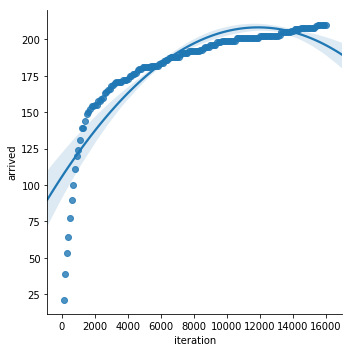

In [8]:
tAco.run_extended(generations=15000, show_progress=True)
sns.lmplot(data=tAco.df_convergence.loc[tAco.df_convergence.iteration % 100 == 0], x="iteration", y="arrived", order=2)
plt.show()

In [13]:
widgets.interact(tAco.draw_pheromones,
                 label=False,
                 width=15, height=15,
                 show=widgets.fixed(True),
                 prune=widgets.FloatSlider(value=0.0, min=0.0, max=0.50, step=0.05),
                 generation=widgets.IntSlider(min=-1,max=len(tAco.pheromone_timeline)-1,step=1,value=-1),
                 thickness=widgets.FloatLogSlider(value=3)
                );

interactive(children=(Checkbox(value=False, description='label'), IntSlider(value=-1, description='generation'…

In [ ]:
widgets.interact(tAco.draw_extended_pheromones,
                 label=False,
                 width=15, height=15,
                 show=widgets.fixed(True),
                 prune=widgets.FloatSlider(value=0.0, min=0.0, max=0.50, step=0.05),
                 time=widgets.IntSlider(min=-1,max=tAco.timeframe-1,step=1,value=-1),
                 thickness=widgets.FloatLogSlider(value=3, base=10, min=-5, max=5)
                )

interactive(children=(Checkbox(value=False, description='label'), IntSlider(value=-1, description='time', max=…

In [529]:
class MultiAgentTACO:
    def __init__(self, adjacency=None, agents=None, timeframe=100, **kwargs):
        self.agents = agents
        self.adjacency = adjacency
        self.timeframe = timeframe
        for agent in self.agents:
            agent["tAco"] = TimeExtendedACO(timeframe=timeframe, adjacency=adjacency, start=agent["start"], goal=agent["goal"], prerun_generations=0)
            print(f"start {agent['start']}, goal {agent['goal']}")
            for t in range(timeframe):
                agent["tAco"].extended_pheromones[t] = agent["tAco"].pheromones
        
    def pheromone_sum(self):
        pheromones = np.zeros_like(self.agents[0]["tAco"].extended_pheromones)
        for agent in self.agents:
            pheromones += agent["tAco"].extended_pheromones
        return pheromones
        
    
    def run(self, show_progress=False, generations=1000, **kwargs):
        if show_progress:
            progress_bar = widgets.IntProgress(min=0, max=generations, value=0)
            display(progress_bar)
        for generation in range(generations):
            if show_progress:
                progress_bar.value=generation
            self.step(**kwargs)
        
    def step(self, batch_size=10, **kwargs):
        for agent in self.agents:
            agent["tAco"].run_extended(generations=batch_size, foreign_pheromones=self.pheromone_sum() - agent["tAco"].extended_pheromones, **kwargs)
    
    def draw_extended_pheromones(self, label=True, time=-1, width=15, height=15, thickness=3, show=True, prune=0, node_label=True, agent=0):
        tAco = self.agents[agent]["tAco"]
        tAco.draw_extended_pheromones(label=label, time=time, width=width, height=height, thickness=thickness, show=show, prune=prune, node_label=node_label)

In [530]:
mAco = MultiAgentTACO(adjacency=m.todense(), agents=[{"start":graphstart, "goal":graphgoal}, {"start":graphgoal, "goal":graphstart}], timeframe=10, prerun_generations=100)
#mAco.step(alpha_foreign=0.5)

start 0, goal 3
start 3, goal 0


In [531]:
mAco.run(show_progress=True, generations=1000, eps=0.5, alpha_foreign=1, alpha=1, beta=0.1)

IntProgress(value=0, max=1000)

iteration 1000 --  arrived: 1652, timeout: 92, ratio: 0.9472477064220184
iteration 1000 --  arrived: 1634, timeout: 84, ratio: 0.9511059371362048
iteration 2000 --  arrived: 3381, timeout: 170, ratio: 0.9521261616446072
iteration 2000 --  arrived: 3300, timeout: 168, ratio: 0.9515570934256056
iteration 3000 --  arrived: 5048, timeout: 254, ratio: 0.952093549603923
iteration 3000 --  arrived: 4994, timeout: 252, ratio: 0.9519634006862371
iteration 4000 --  arrived: 6721, timeout: 329, ratio: 0.9533333333333334
iteration 4000 --  arrived: 6631, timeout: 349, ratio: 0.95
iteration 5000 --  arrived: 8436, timeout: 406, ratio: 0.9540827866998417
iteration 5000 --  arrived: 8312, timeout: 428, ratio: 0.9510297482837529
iteration 6000 --  arrived: 10104, timeout: 494, ratio: 0.9533874315908663
iteration 6000 --  arrived: 9977, timeout: 516, ratio: 0.9508243590965405
iteration 7000 --  arrived: 11736, timeout: 588, ratio: 0.952288218111003
iteration 7000 --  arrived: 11598, timeout: 619, ratio

KeyboardInterrupt: 

In [532]:
widgets.interact(mAco.draw_extended_pheromones,
                 label=False,
                 width=15, height=15,
                 show=widgets.fixed(True),
                 prune=widgets.FloatSlider(value=0.0, min=0.0, max=0.50, step=0.05),
                 time=widgets.IntSlider(min=-1,max=mAco.timeframe-1,step=1,value=-1),
                 agent=widgets.Dropdown(options=range(len(mAco.agents))),
                 thickness=widgets.FloatLogSlider(value=3, base=10, min=-5, max=5)
                );

interactive(children=(Checkbox(value=False, description='label'), IntSlider(value=-1, description='time', max=…

In [ ]:
mAco.agents[1]["tAco"].draw_extended_pheromones(time=1)

In [444]:
matrix = mAco.pheromone_sum()-mAco.agents[0]["tAco"].extended_pheromones
pd.DataFrame(matrix[0])

,0,1,2,3
0,0.0,0.0,0.0,0.000000e+00
1,0.0,0.0,0.0,0.000000e+00
2,0.0,0.0,0.0,0.000000e+00
3,0.0,4.0,0.0,8.933979e-37


In [445]:
pd.DataFrame(mAco.agents[1]["tAco"].extended_pheromones[0])

,0,1,2,3
0,0.0,0.0,0.0,0.000000e+00
1,0.0,0.0,0.0,0.000000e+00
2,0.0,0.0,0.0,0.000000e+00
3,0.0,4.0,0.0,8.933979e-37


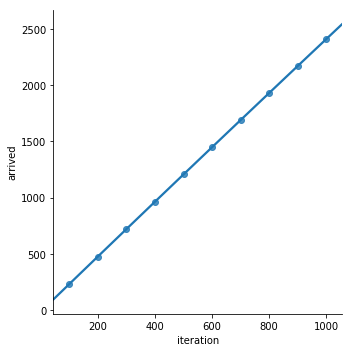

In [433]:
mAco.agents[0]["tAco"].plot_convergence()

In [435]:
mAco.agents[1]["tAco"].extended_pheromones_sum()

array([[3.20000000e+000, 1.69315593e-148, 0.00000000e+000,
        0.00000000e+000],
       [4.00000000e-001, 2.36740648e-055, 2.58814341e-026,
        6.53742276e-149],
       [0.00000000e+000, 2.55348674e-026, 2.40429936e-026,
        0.00000000e+000],
       [0.00000000e+000, 4.00000000e-001, 0.00000000e+000,
        1.11984989e-017]])